# Libraries

In [1]:
# tensorflow utils
import tensorflow as tf

# matplotlib utils
import matplotlib as mpl
import matplotlib.pyplot as plt

# other useful
import numpy as np
import pandas as pd
import seaborn as sn

# pyplot config
mpl.rcParams['font.family'] = 'Iosevka Flat'

# Datasets

In [2]:
( (p_images, p_labels),
  (q_images, q_labels), ) = tf.keras.datasets.fashion_mnist.load_data()

# normalize
p_images = p_images / 255.0
q_images = q_images / 255.0

# Noises

In [3]:
class CauchyNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, amplify: float, clip=(0, 1)):
        super(CauchyNoiseLayer, self).__init__()
        self.clip = clip
        self.amplify = amplify

    def call(self, inputs, training=None):
        r1 = tf.random.normal(shape=tf.shape(inputs), mean=0, stddev=1)
        r2 = tf.random.normal(shape=tf.shape(inputs), mean=0, stddev=1)
        return tf.clip_by_value(inputs + self.amplify*(r1 / r2), self.clip[0], self.clip[1])

class NormalNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, mean: float, stddev: float, clip=(0, 1)):
        super(NormalNoiseLayer, self).__init__()
        self.clip = clip
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs, training=None):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
        return tf.clip_by_value(inputs + noise, self.clip[0], self.clip[1])

class UniformNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, minval: float, maxval: float, clip=(0, 1)):
        super(UniformNoiseLayer, self).__init__()
        self.clip = clip
        self.minval = minval
        self.maxval = maxval
        
    def call(self, inputs, training=None):
        noise = tf.random.uniform(shape=tf.shape(inputs), minval=self.minval, maxval=self.maxval)
        return tf.clip_by_value(inputs + noise, self.clip[0], self.clip[1])

# Model

In [4]:
model = tf.keras.models.load_model('../models/model.fashion_mnist.keras')

# Test :: without noise

In [5]:
# evaluation
p_eval = model.evaluate(p_images, p_labels)
q_eval = model.evaluate(q_images, q_labels)

# prediction
p_pred = model.predict(p_images).argmax(-1)
q_pred = model.predict(q_images).argmax(-1)

# confusion
p_conf = tf.math.confusion_matrix(p_labels, p_pred)
q_conf = tf.math.confusion_matrix(q_labels, q_pred)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9542 - loss: 0.1200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9214 - loss: 0.2264
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


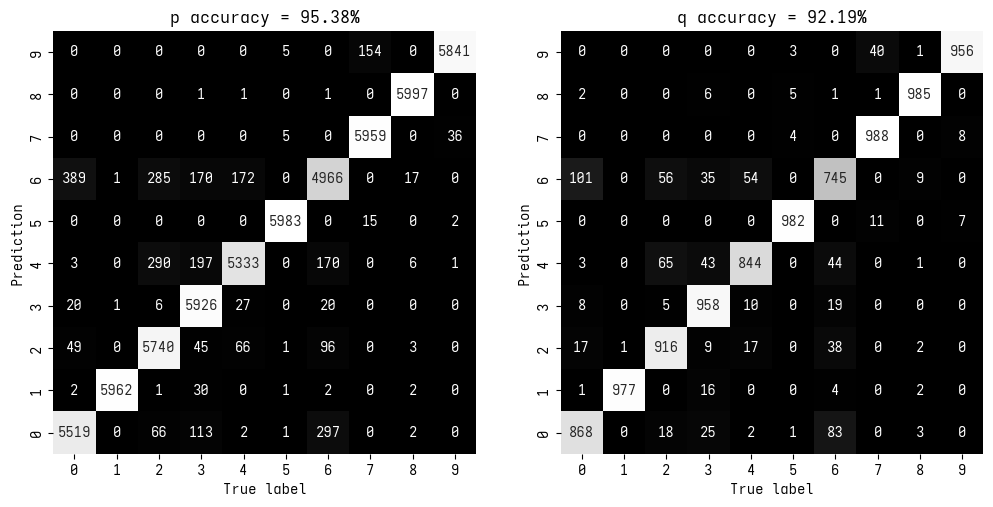

In [6]:
plt.figure(figsize=(12, 8))

# visualize p confusion matrix
plt.subplot(1, 2, 1)
sn.heatmap(pd.DataFrame(p_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
plt.title(f'p accuracy = {p_eval[1]:.2%}')
plt.xlabel('True label')
plt.ylabel('Prediction')

# visualize q confusion matrix
plt.subplot(1, 2, 2)
sn.heatmap(pd.DataFrame(q_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
plt.title(f'q accuracy = {q_eval[1]:.2%}')
plt.xlabel('True label')
plt.ylabel('Prediction')

plt.show()

# Test :: with Cauchy noise

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9214 - loss: 0.2264
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


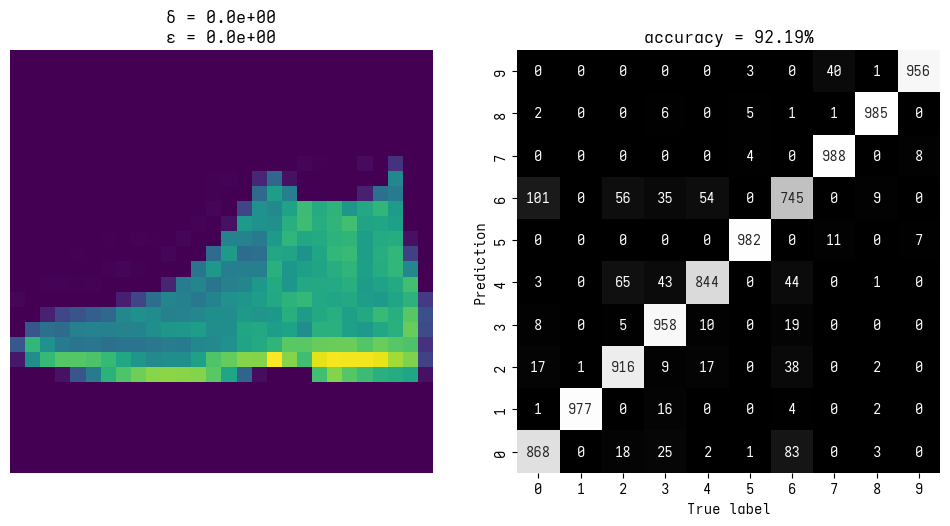

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9078 - loss: 0.2597
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


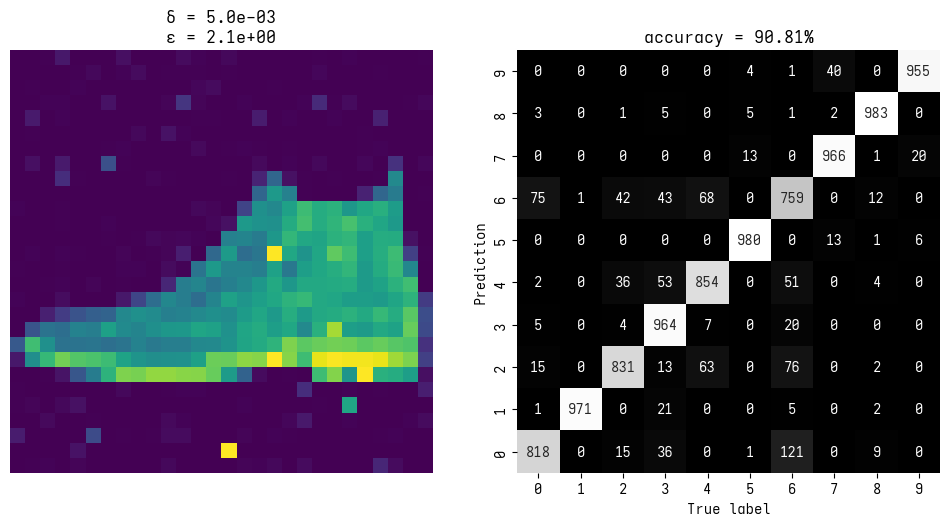

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8858 - loss: 0.3188
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


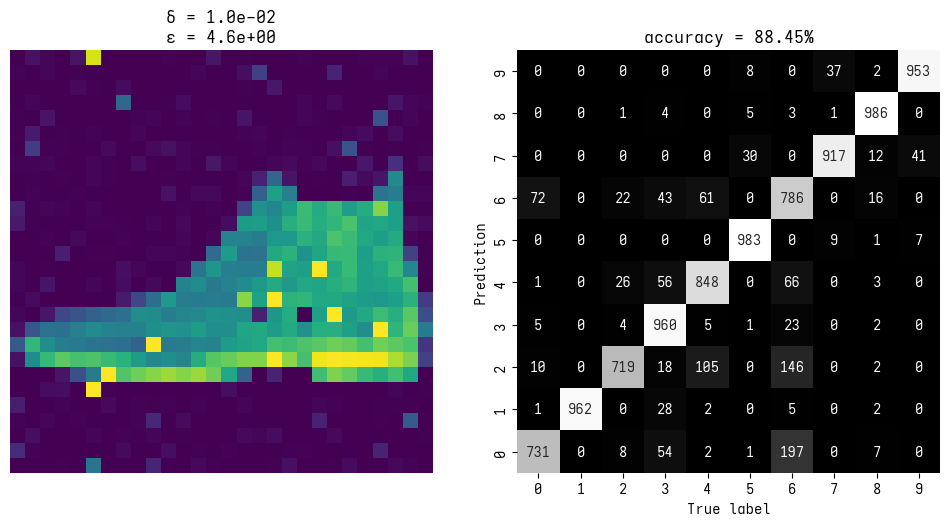

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8531 - loss: 0.3991
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


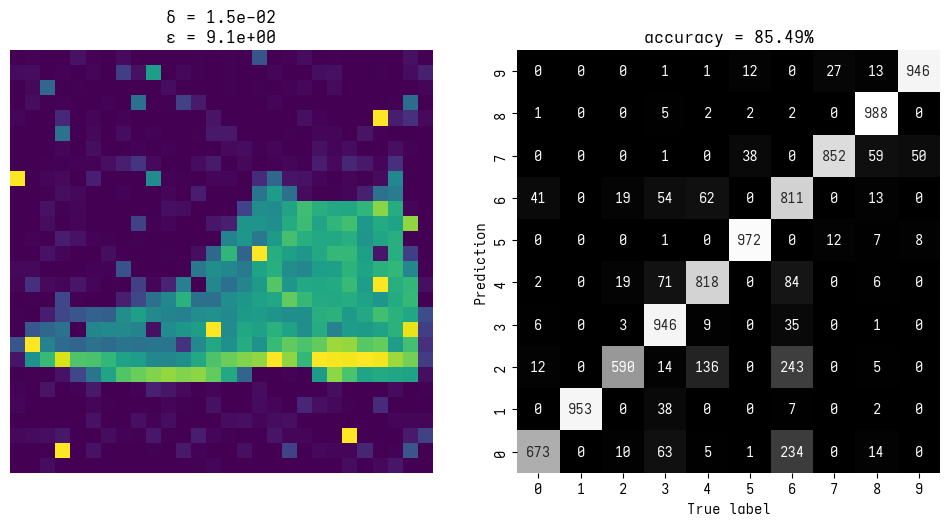

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8106 - loss: 0.4982
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


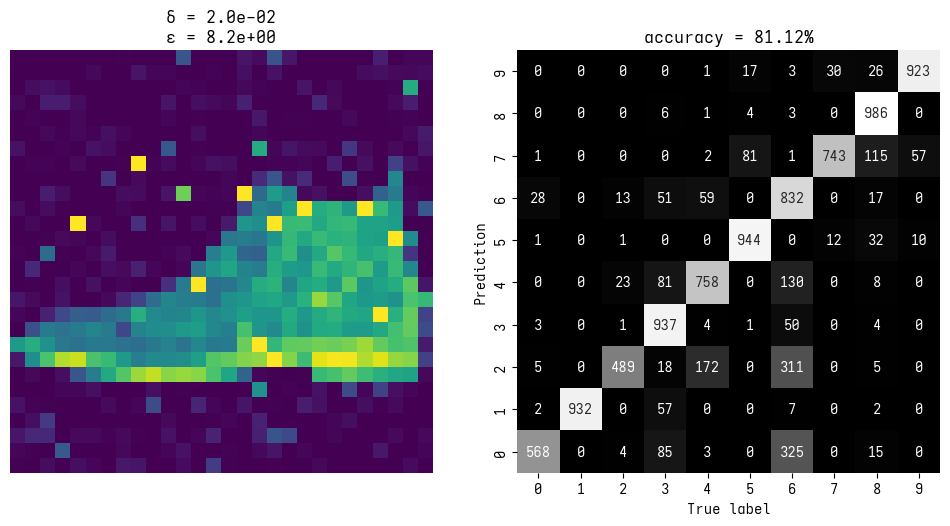

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7683 - loss: 0.6193
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


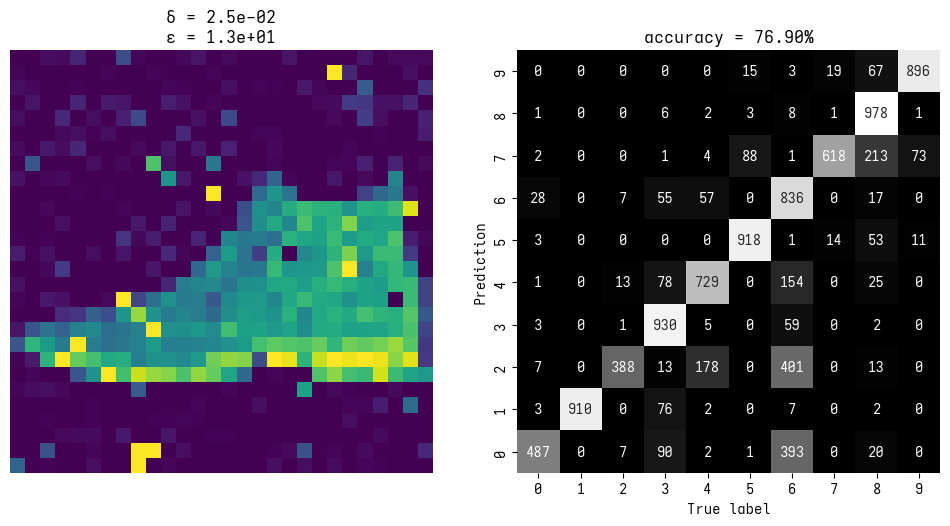

In [7]:
for noise_level in (0, .005, .010, .015, .020, .025):
    q_noised = CauchyNoiseLayer(amplify=noise_level)(q_images)

    # evaluation
    q_eval = model.evaluate(q_noised, q_labels)

    # prediction
    q_pred = model.predict(q_noised).argmax(-1)

    # confusion
    q_conf = tf.math.confusion_matrix(q_labels, q_pred)

    plt.figure(figsize=(12, 8))

    # visualize noised digit
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(f'δ = {noise_level:1.1e}\nε = {((q_images[0] - q_noised[0]) ** 2).numpy().sum():1.1e}')
    plt.imshow(q_noised[0])

    # visualize confusion matrix
    plt.subplot(1, 2, 2)
    sn.heatmap(pd.DataFrame(q_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
    plt.title(f'accuracy = {q_eval[1]:.2%}')
    plt.xlabel('True label')
    plt.ylabel('Prediction')

    plt.show()

# Test :: with Normal noise

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9214 - loss: 0.2264
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


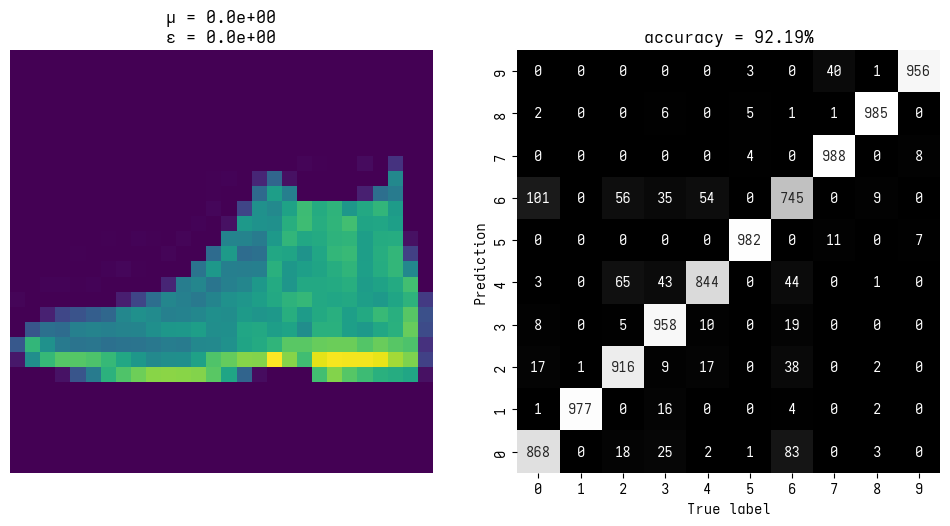

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9200 - loss: 0.2265
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


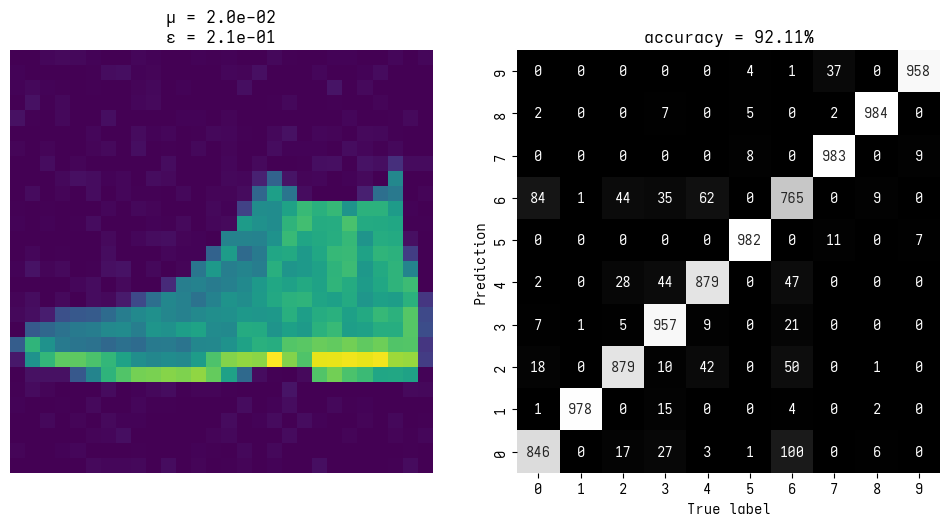

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9019 - loss: 0.2614
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


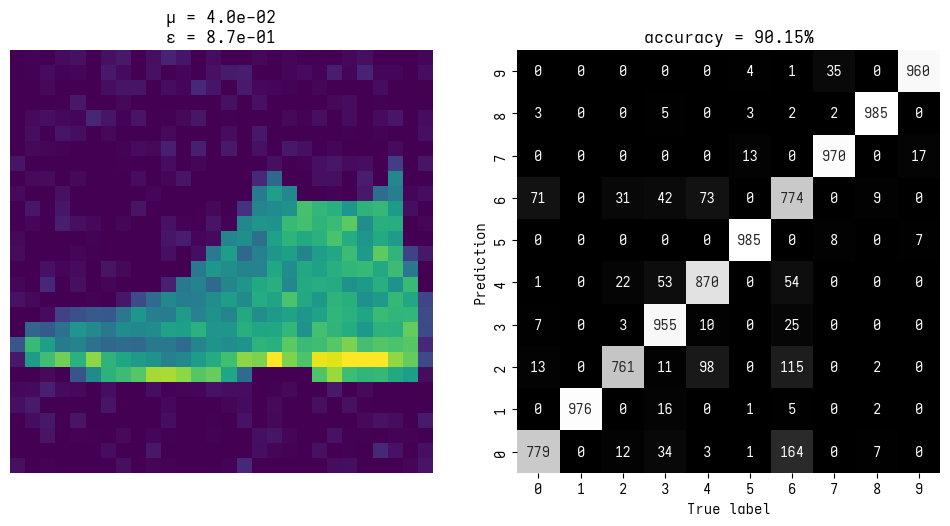

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8726 - loss: 0.3365
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


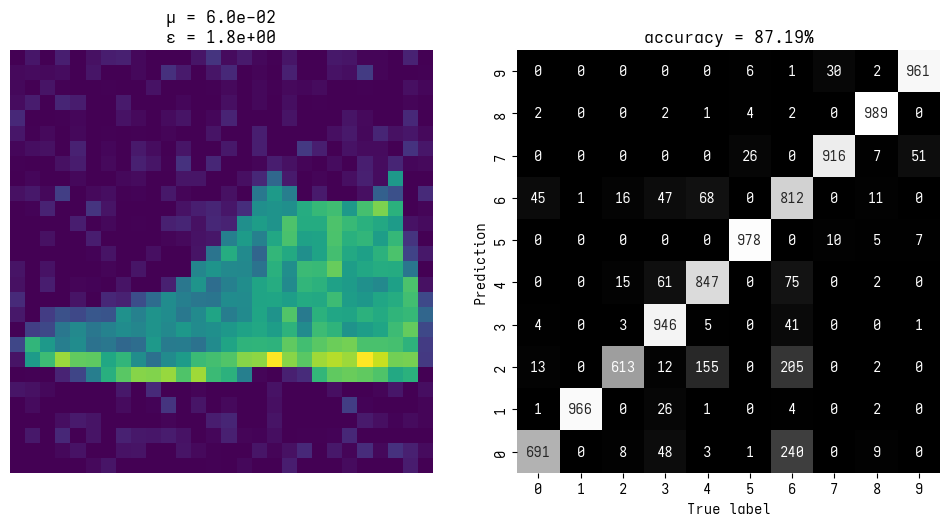

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8267 - loss: 0.4456
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


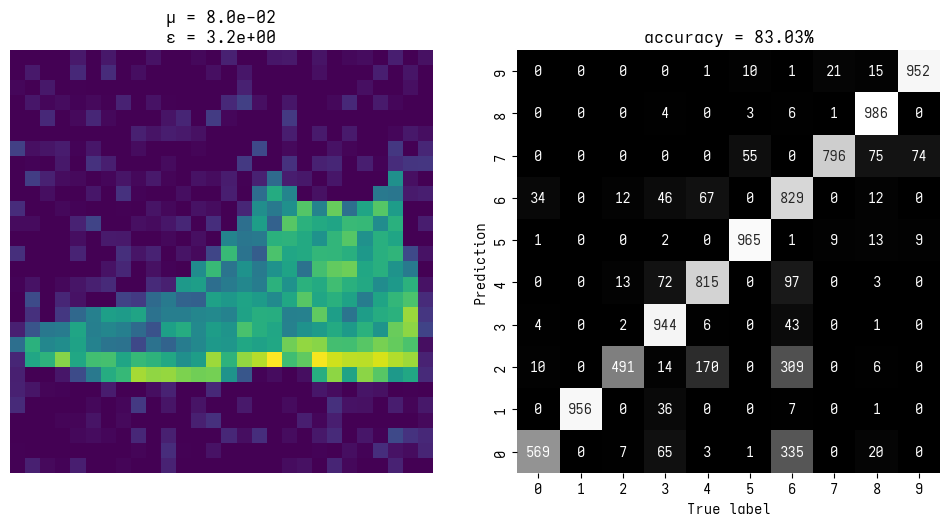

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7620 - loss: 0.6199
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


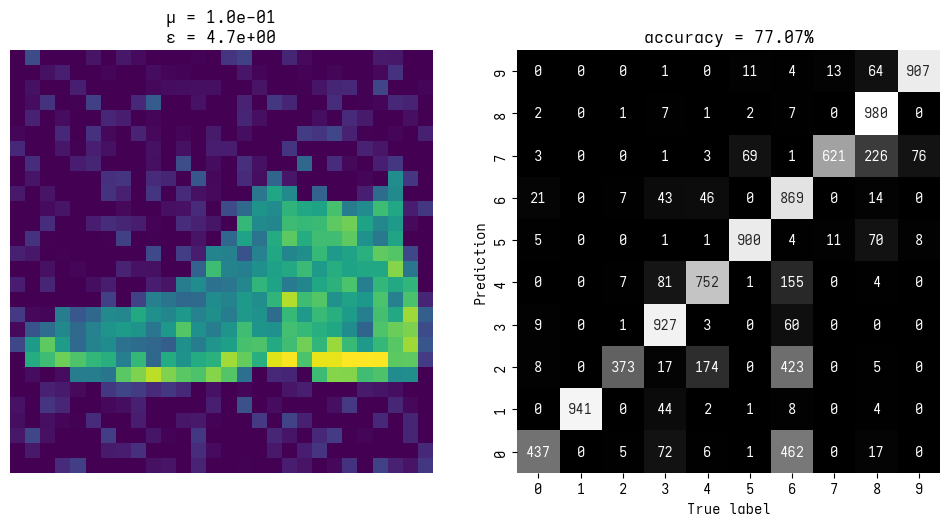

In [8]:
for noise_level in (0, .02, .04, .06, .08, .10):
    q_noised = NormalNoiseLayer(mean=0, stddev=noise_level)(q_images)

    # evaluation
    q_eval = model.evaluate(q_noised, q_labels)

    # prediction
    q_pred = model.predict(q_noised).argmax(-1)

    # confusion
    q_conf = tf.math.confusion_matrix(q_labels, q_pred)

    plt.figure(figsize=(12, 8))

    # visualize noised digit
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(f'μ = {noise_level:1.1e}\nε = {((q_images[0] - q_noised[0]) ** 2).numpy().sum():1.1e}')
    plt.imshow(q_noised[0])

    # visualize confusion matrix
    plt.subplot(1, 2, 2)
    sn.heatmap(pd.DataFrame(q_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
    plt.title(f'accuracy = {q_eval[1]:.2%}')
    plt.xlabel('True label')
    plt.ylabel('Prediction')

    plt.show()

# Test :: with Uniform noise

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9214 - loss: 0.2264
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


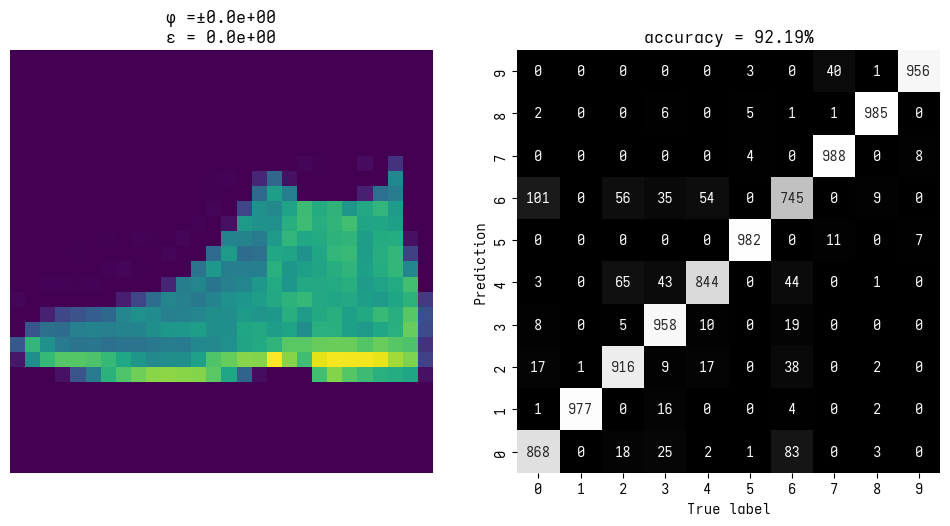

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9171 - loss: 0.2348
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


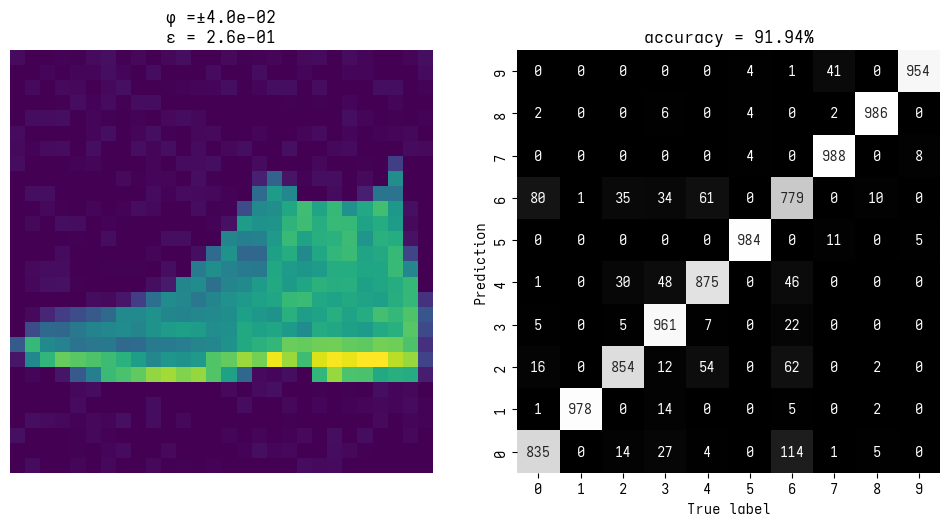

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8953 - loss: 0.2833
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


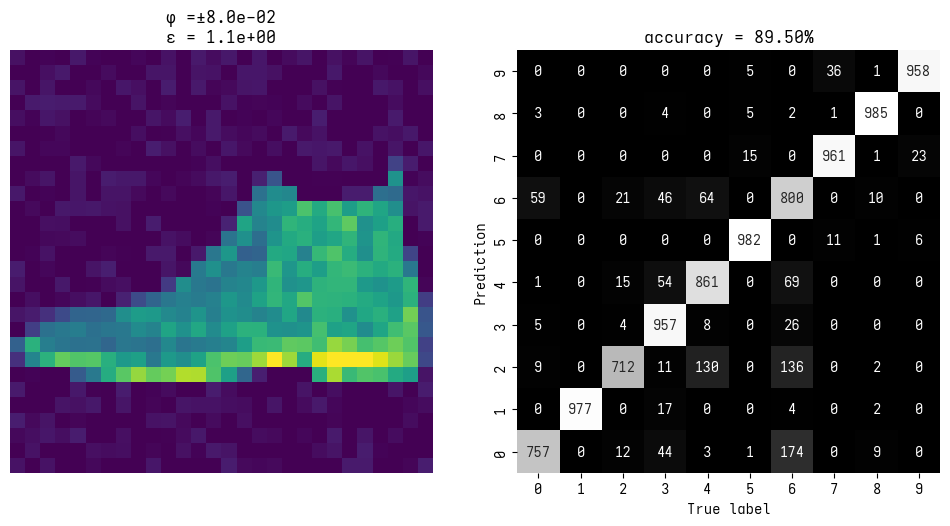

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8501 - loss: 0.3969
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


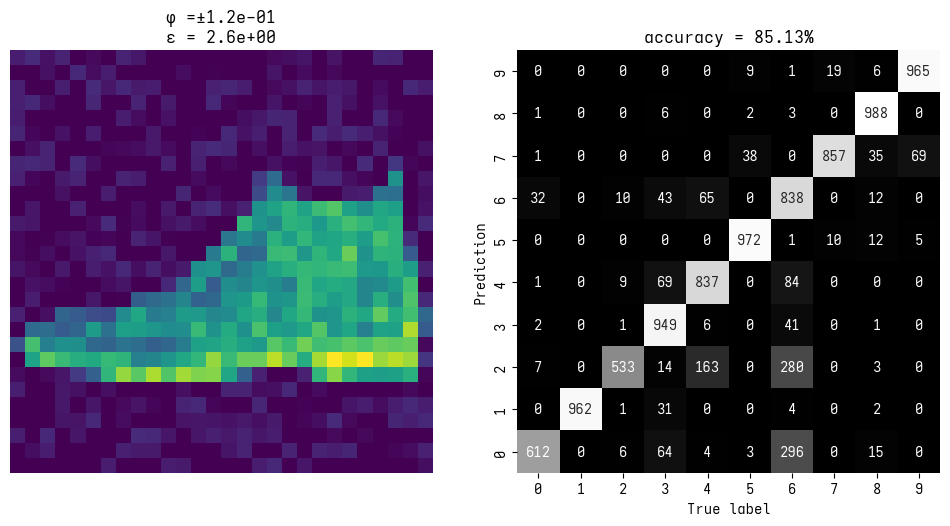

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7854 - loss: 0.5697
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


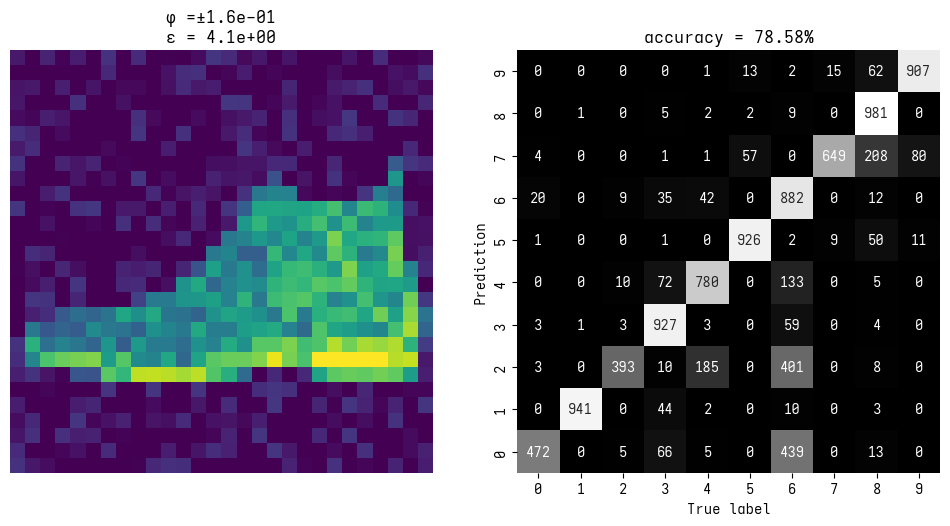

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7028 - loss: 0.8063
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


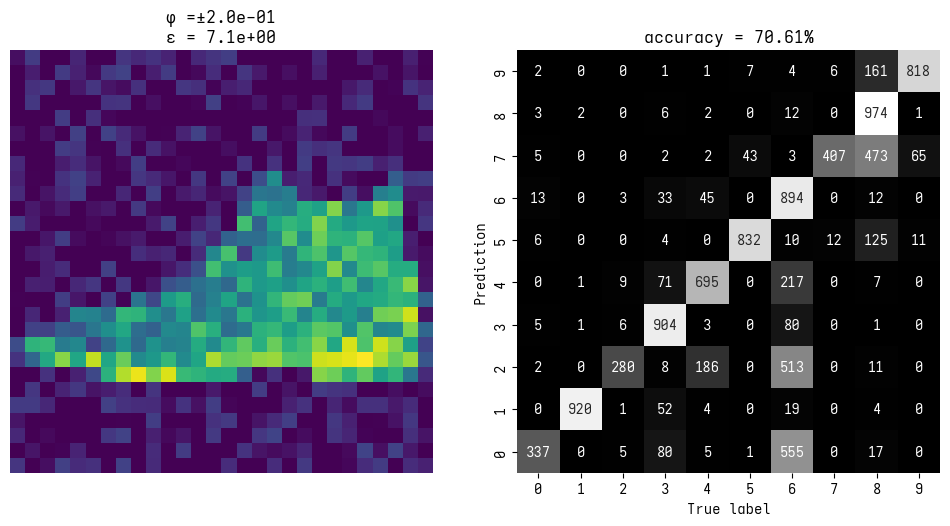

In [9]:
for noise_level in (0, .04, .08, .12, .16, .20):
    q_noised = UniformNoiseLayer(minval=-noise_level, maxval=+noise_level)(q_images)

    # evaluation
    q_eval = model.evaluate(q_noised, q_labels)

    # prediction
    q_pred = model.predict(q_noised).argmax(-1)

    # confusion
    q_conf = tf.math.confusion_matrix(q_labels, q_pred)

    plt.figure(figsize=(12, 8))

    # visualize noised digit
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(f'φ =±{noise_level:1.1e}\nε = {((q_images[0] - q_noised[0]) ** 2).numpy().sum():1.1e}')
    plt.imshow(q_noised[0])

    # visualize confusion matrix
    plt.subplot(1, 2, 2)
    sn.heatmap(pd.DataFrame(q_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
    plt.title(f'accuracy = {q_eval[1]:.2%}')
    plt.xlabel('True label')
    plt.ylabel('Prediction')

    plt.show()